In [ ]:
!pip install yfinance scikit-learn matplotlib tensorflow

# Single Prediction with LSTM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf
import joblib
import time
import matplotlib.dates as mdates

# Mulai Waktu Eksekusi
start_time = time.time()
print("🚀 Mulai eksekusi...")

# === 1. Ambil Data dari Yahoo Finance ===
ticker = 'BBTN.JK'
start_date = '2016-01-01'
end_date = '2024-01-01'

data = yf.download(ticker, start=start_date, end=end_date)
data.dropna(inplace=True)
data.index.name = 'Date'
print(f"📊 Total data diambil: {len(data)} hari")

# === 2. Scaling Data ===
features = ['Open', 'High', 'Low', 'Close', 'Volume']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# === 3. Buat Dataset Time Series ===
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step])
        y.append(dataset[i + time_step, features.index('Close')])
    return np.array(X), np.array(y)

time_step = 60
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - time_step:]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], time_step, len(features))
X_test = X_test.reshape(X_test.shape[0], time_step, len(features))

# === 4. Bangun Model LSTM ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_step, len(features))),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32),
    Dense(1)
])
model.compile(optimizer=Nadam(), loss='mean_squared_error')

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, callbacks=[early_stop])

# Simpan model dan scaler
model.save('model_saham_lstm_bbtn.keras')
joblib.dump(scaler, 'scaler_saham_bbtn.pkl')
print("💾 Model dan scaler berhasil disimpan!")

# === 5. Prediksi dan Evaluasi ===
predicted_scaled = model.predict(X_test)
# Hanya isi kolom 'Close' saat inverse transform
pad_pred = np.zeros((len(predicted_scaled), len(features)))
pad_pred[:, features.index('Close')] = predicted_scaled[:, 0]
predicted = scaler.inverse_transform(pad_pred)[:, features.index('Close')]

# Data aktual
pad_actual = np.zeros((len(y_test), len(features)))
pad_actual[:, features.index('Close')] = y_test
actual = scaler.inverse_transform(pad_actual)[:, features.index('Close')]

# Hitung MAPE
mape = mean_absolute_percentage_error(actual, predicted) * 100
print(f"📉 MAPE pada data uji: {mape:.2f}%")

# === 6. Visualisasi ===
actual_dates = data.index[-len(actual):]

plt.figure(figsize=(14, 6))
plt.plot(actual_dates, actual, label='Harga Aktual')
plt.plot(actual_dates, predicted, 'r--', label='Prediksi')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.title(f'Prediksi Harga Saham {ticker} (Single-Step)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 7. Selesai ===
end_time = time.time()
print(f"\n✅ Eksekusi selesai. Waktu yang dibutuhkan: {end_time - start_time:.2f} detik")


# Load Single Prediction with LSTM

[*********************100%***********************]  1 of 1 completed

✅ Model dan scaler berhasil dimuat!
📅 Mengambil data dari 2023-05-21 hingga 2025-05-20


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Price        Close    High     Low    Open    Volume
Ticker     BBTN.JK BBTN.JK BBTN.JK BBTN.JK   BBTN.JK
Date                                                
2025-05-09  1150.0  1175.0  1130.0  1165.0  28497400
2025-05-14  1220.0  1225.0  1155.0  1170.0  93784100
2025-05-15  1240.0  1260.0  1225.0  1225.0  56684700
2025-05-16  1250.0  1255.0  1215.0  1250.0  34963300
2025-05-19  1240.0  1260.0  1230.0  1250.0  34406100

📈 Prediksi harga saham BBTN.JK untuk 2025-05-21: Rp1,271.91


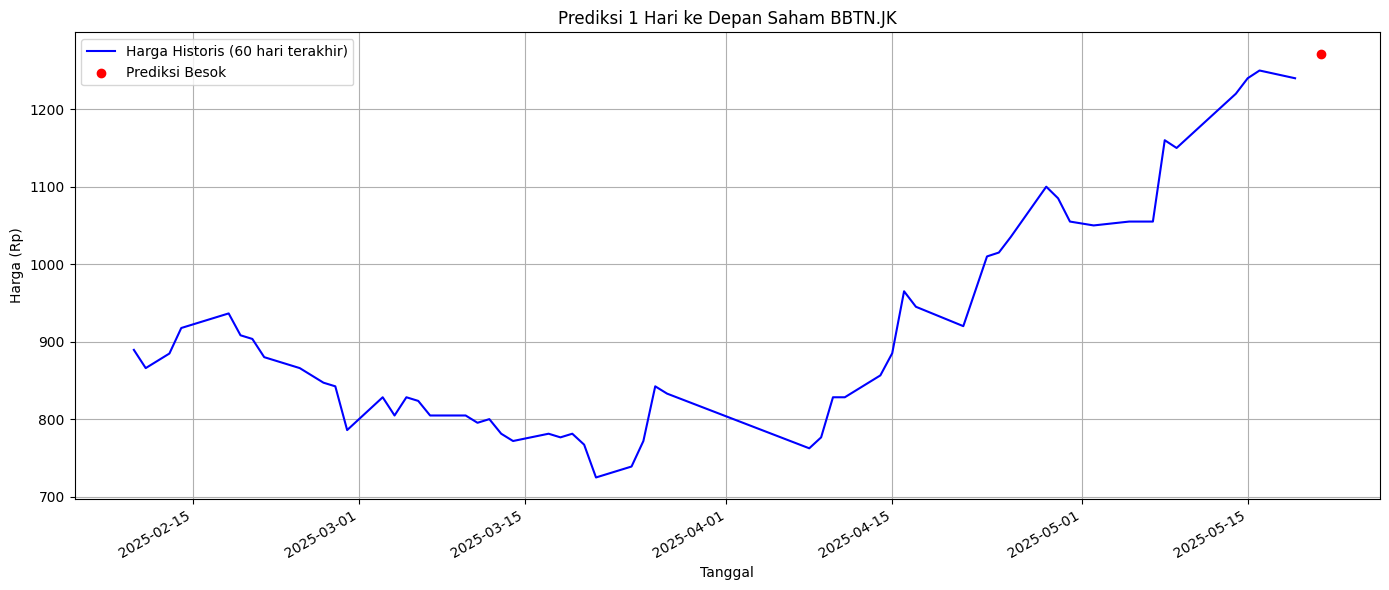

In [ ]:
from tensorflow.keras.models import load_model
from datetime import datetime, timedelta
import joblib
import yfinance as yf
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
jakarta_tz = pytz.timezone('Asia/Jakarta')
now_jakarta = datetime.now(jakarta_tz)

# === 1. Load Model dan Scaler ===
model = load_model('model_saham_lstm_single_step.keras')
scaler = joblib.load('scaler_saham_single_step.pkl')
print("✅ Model dan scaler berhasil dimuat!")

# === 2. Ambil Data Terbaru ===
ticker = 'BBTN.JK'
end_date = now_jakarta.date()
start_date = end_date - timedelta(days=365 * 2)
print(f"📅 Mengambil data dari {start_date} hingga {end_date}")

data = yf.download(ticker, start=start_date, end=end_date)
data.dropna(inplace=True)
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# === 3. Siapkan Input untuk Prediksi ===
scaled_data = scaler.transform(data[features])
last_60_scaled = scaled_data[-60:].reshape(1, 60, len(features))
last_60_dates = data.index[-60:]

# === 4. Prediksi 1 Hari ke Depan ===
pred_scaled = model.predict(last_60_scaled)[0, 0]

pad = np.zeros((1, len(features)))
pad[0, features.index('Close')] = pred_scaled
predicted_price = scaler.inverse_transform(pad)[0, features.index('Close')]

tomorrow = now_jakarta + timedelta(days=1)
print(f"\n📈 Prediksi harga saham {ticker} untuk {tomorrow.date()}: Rp{predicted_price:,.2f}")

# === 5. Visualisasi Harga Historis + Titik Prediksi ===
plt.figure(figsize=(14, 6))
plt.plot(last_60_dates, data['Close'][-60:], label='Harga Historis (60 hari terakhir)', color='blue')
plt.scatter(tomorrow, predicted_price, color='red', label='Prediksi Besok', zorder=5)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.title(f'Prediksi 1 Hari ke Depan Saham {ticker}')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Multiple Prediction with LSTM

[*********************100%***********************]  1 of 1 completed

🚀 Mulai eksekusi...
📊 Total data diambil: 1993 hari
Epoch 1/100



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0561
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0055
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0042
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.0041
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0039
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0033
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0027
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0029
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.0026
Epoch 10/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0023
Epoch 11/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0022
Epoch 12/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0021
Epoch 13/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0022
Epoch 14/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 0.0022
Epoch 15/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss:

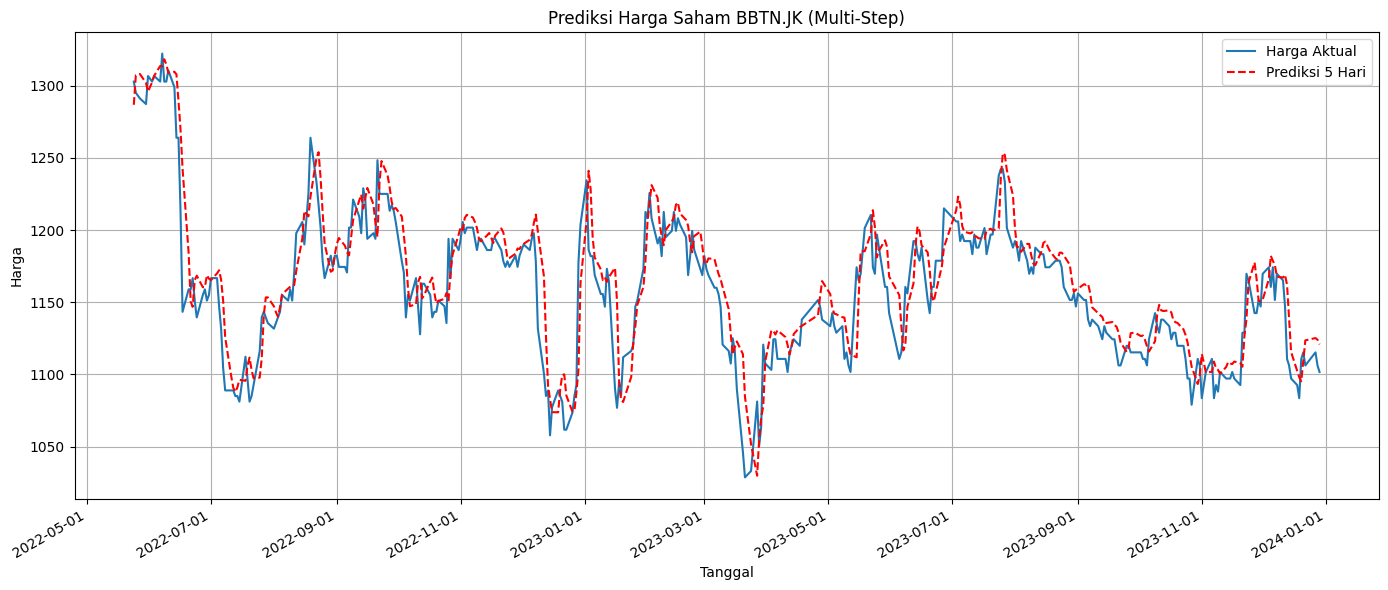


✅ Eksekusi selesai. Waktu yang dibutuhkan: 571.37 detik


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf
import joblib
import time
import matplotlib.dates as mdates

# Mulai Waktu Eksekusi
start_time = time.time()
print("🚀 Mulai eksekusi...")

# === 1. Ambil Data dari Yahoo Finance ===
ticker = 'BBTN.JK'
start_date = '2016-01-01'
end_date = '2024-01-01'

data = yf.download(ticker, start=start_date, end=end_date)
data.dropna(inplace=True)
data.index.name = 'Date'
print(f"📊 Total data diambil: {len(data)} hari")

# === 2. Scaling Data ===
features = ['Open', 'High', 'Low', 'Close', 'Volume']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# === 3. Buat Dataset Time Series (Multi-Step) ===
def create_dataset(dataset, time_step=60, n_steps=5):
    X, y = [], []
    for i in range(len(dataset) - time_step - n_steps + 1):
        X.append(dataset[i:i + time_step])
        y.append(dataset[i + time_step:i + time_step + n_steps, features.index('Close')])
    return np.array(X), np.array(y)

n_steps = 5  # Jumlah langkah prediksi (5 hari ke depan)
time_step = 60
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - time_step:]

X_train, y_train = create_dataset(train_data, time_step, n_steps)
X_test, y_test = create_dataset(test_data, time_step, n_steps)

X_train = X_train.reshape(X_train.shape[0], time_step, len(features))
X_test = X_test.reshape(X_test.shape[0], time_step, len(features))

# === 4. Bangun Model LSTM untuk Multi-Step ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_step, len(features))),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32),
    Dense(n_steps)  # Ubah output layer untuk prediksi beberapa langkah
])
model.compile(optimizer=Nadam(), loss='mean_squared_error')

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, callbacks=[early_stop])

# Simpan model dan scaler
model.save('model_saham_lstm_bbtn_multi_step.keras')
joblib.dump(scaler, 'scaler_saham_bbtn_multi_step.pkl')
print("💾 Model dan scaler berhasil disimpan!")

# === 5. Prediksi dan Evaluasi ===
predicted_scaled = model.predict(X_test)

# Menyusun prediksi dengan format yang benar
pad_pred = np.zeros((len(predicted_scaled), len(features)))
pad_pred[:, features.index('Close')] = predicted_scaled[:, 0]
predicted = scaler.inverse_transform(pad_pred)[:, features.index('Close')]

# Data aktual
pad_actual = np.zeros((len(y_test), len(features)))
pad_actual[:, features.index('Close')] = y_test[:, 0]  # Ambil harga 'Close' saja
actual = scaler.inverse_transform(pad_actual)[:, features.index('Close')]

# Hitung MAPE untuk setiap hari yang diprediksi
mape = mean_absolute_percentage_error(actual, predicted) * 100
print(f"📉 MAPE pada data uji: {mape:.2f}%")

# === 6. Visualisasi ===
actual_dates = data.index[-len(actual):]

plt.figure(figsize=(14, 6))
plt.plot(actual_dates, actual, label='Harga Aktual')
plt.plot(actual_dates, predicted, 'r--', label=f'Prediksi {n_steps} Hari')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.title(f'Prediksi Harga Saham {ticker} (Multi-Step)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 7. Selesai ===
end_time = time.time()
print(f"\n✅ Eksekusi selesai. Waktu yang dibutuhkan: {end_time - start_time:.2f} detik")


# Load Multiple Prediction with LSTM

[*********************100%***********************]  1 of 1 completed

💾 Model dan scaler berhasil dimuat!
📊 Total data diambil: 318 hari


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
📈 Prediksi harga saham BBTN.JK untuk 2025-05-15 00:00:00: Rp1,384.84
📈 Prediksi harga saham BBTN.JK untuk 2025-05-16 00:00:00: Rp1,380.79
📈 Prediksi harga saham BBTN.JK untuk 2025-05-17 00:00:00: Rp1,380.90
📈 Prediksi harga saham BBTN.JK untuk 2025-05-18 00:00:00: Rp1,386.79
📈 Prediksi harga saham BBTN.JK untuk 2025-05-19 00:00:00: Rp1,382.15


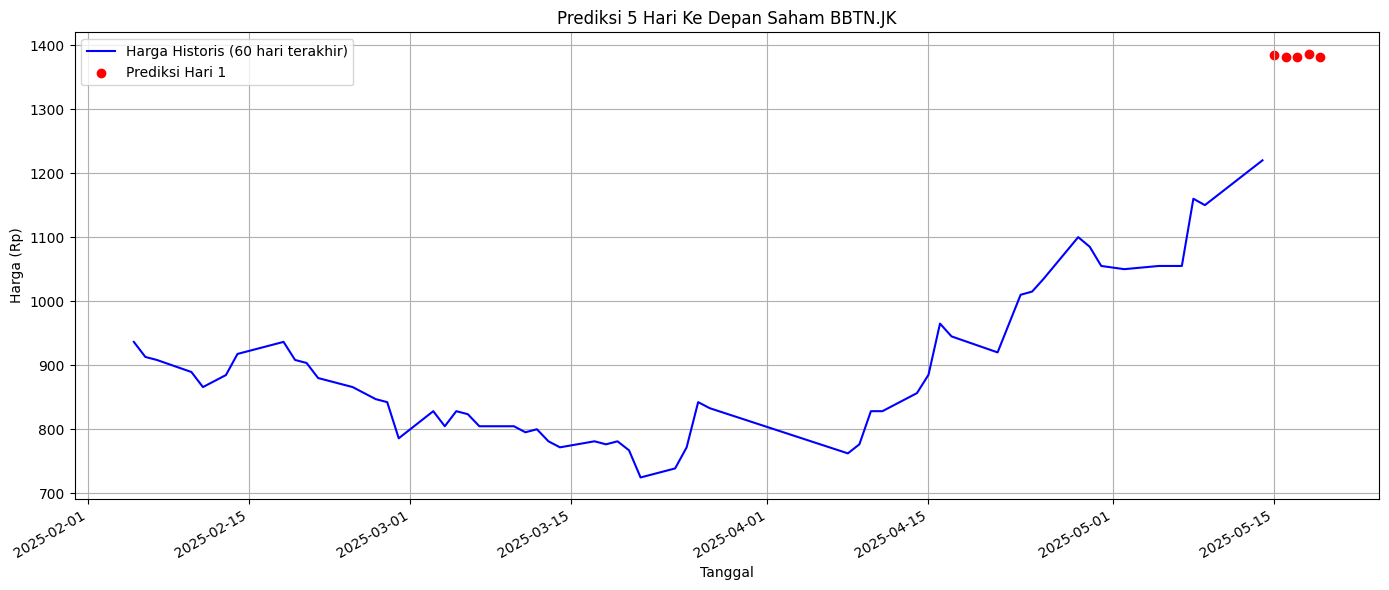

In [ ]:
import numpy as np
import pandas as pd
import joblib
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_percentage_error

# === 1. Load Model dan Scaler ===
model = load_model('model_saham_lstm_bbtn_multi_step.keras')
scaler = joblib.load('scaler_saham_bbtn_multi_step.pkl')

print("💾 Model dan scaler berhasil dimuat!")

# === 2. Ambil Data dari Yahoo Finance ===
ticker = 'BBTN.JK'
start_date = '2024-01-01'  # Ganti dengan periode yang sesuai
end_date = '2025-05-15'    # Ganti dengan periode yang sesuai

data = yf.download(ticker, start=start_date, end=end_date)
data.dropna(inplace=True)
data.index.name = 'Date'

print(f"📊 Total data diambil: {len(data)} hari")

# === 3. Scaling Data ===
features = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled_data = scaler.transform(data[features])

# === 4. Buat Dataset Time Series (Multi-Step) ===
def create_dataset(dataset, time_step=60, n_steps=5):
    X, y = [], []
    for i in range(len(dataset) - time_step - n_steps + 1):
        X.append(dataset[i:i + time_step])
        y.append(dataset[i + time_step:i + time_step + n_steps, features.index('Close')])
    return np.array(X), np.array(y)

n_steps = 5  # Jumlah langkah prediksi (5 hari ke depan)
time_step = 60
X_input, _ = create_dataset(scaled_data, time_step, n_steps)

X_input = X_input.reshape(X_input.shape[0], time_step, len(features))

# === 5. Prediksi dengan Model ===
predicted_scaled = model.predict(X_input)

# Menyusun prediksi dengan format yang benar
predicted_prices = []
for i in range(predicted_scaled.shape[0]):
    pad_pred = np.zeros((n_steps, len(features)))
    pad_pred[:, features.index('Close')] = predicted_scaled[i, :]
    predicted_prices.append(scaler.inverse_transform(pad_pred)[:, features.index('Close')])

predicted_prices = np.array(predicted_prices)

# === 6. Visualisasi Prediksi ===
# Ambil tanggal untuk 5 hari ke depan berdasarkan data yang tersedia
last_date = data.index[-1]
predicted_dates = [last_date + timedelta(days=i+1) for i in range(n_steps)]

plt.figure(figsize=(14, 6))

# Plot harga historis
plt.plot(data.index[-60:], data['Close'][-60:], label='Harga Historis (60 hari terakhir)', color='blue')

# Plot prediksi untuk 5 hari ke depan
for i in range(n_steps):
    plt.scatter(predicted_dates[i], predicted_prices[0, i], color='red', label=f'Prediksi Hari {i+1}' if i == 0 else "")

# Harga 5 hari kedepan
tomorrow = last_date + timedelta(days=1)
for i in range(n_steps):
    print(f"📈 Prediksi harga saham {ticker} untuk {tomorrow + timedelta(days=i)}: Rp{predicted_prices[0, i]:,.2f}")


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.title(f'Prediksi {n_steps} Hari Ke Depan Saham {ticker}')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 7. Evaluasi (Jika Tersedia Data Aktual) ===
# Jika kamu memiliki data aktual untuk periode yang diprediksi
# Misalnya jika kamu punya data nyata 'actual' untuk periode ini
# kamu bisa menghitung MAPE jika data aktual tersedia
# actual = [harga aktual]
# mape = mean_absolute_percentage_error(actual, predicted_prices.flatten()) * 100
# print(f"📉 MAPE: {mape:.2f}%")


[*********************100%***********************]  1 of 1 completed


✅ Model and scaler successfully loaded.
📊 Retrieved BBRI.JK data from 2024-01-01 to 2025-05-01
📈 Forecast for 7 days ahead: 1254.79
📈 Forecast for 30 days ahead: 1172.55
📈 Forecast for 60 days ahead: 1168.36
📈 Forecast for 90 days ahead: 1168.35
📈 Forecast for 120 days ahead: 1168.35


<ipython-input-23-ea254e29d4e1>:80: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


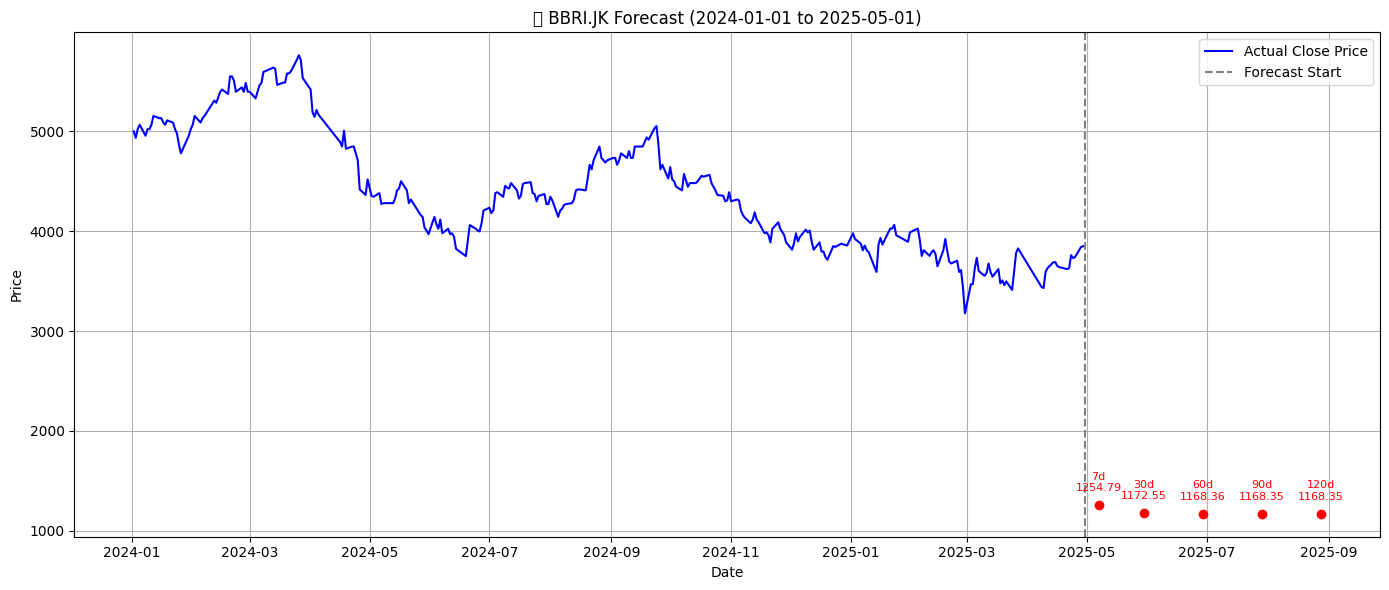

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# === 1. Load Model and Scaler ===
model = load_model('model_saham_lstm.h5')  # Or .keras if you use the new format
scaler = joblib.load('scaler_saham.pkl')
print("✅ Model and scaler successfully loaded.")

# === 2. Download Data from Yahoo Finance ===
def fetch_yahoo_data(ticker, start_date='2024-01-01', end_date='2025-05-01'):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.dropna(inplace=True)
    data.index.name = 'Date'
    print(f"📊 Retrieved {ticker} data from {start_date} to {end_date}")
    return data

# === 3. Recursive Forecasting Function ===
def recursive_forecast(model, last_data, steps, features):
    predictions = []
    current_input = last_data.copy()  # Shape: (1, time_step, num_features)

    for _ in range(steps):
        pred_scaled = model.predict(current_input, verbose=0)

        # Pad and inverse transform the prediction
        pad = np.zeros((1, len(features)))
        pad[0, features.index('Close')] = pred_scaled[0, 0]
        inv_scaled = scaler.inverse_transform(pad)[0, features.index('Close')]
        predictions.append(inv_scaled)

        # Update the input window
        new_input = current_input[0, 1:, :].tolist()  # Drop first row
        new_close_scaled = pad[0].reshape(1, -1)
        new_input.append(new_close_scaled[0])
        current_input = np.array([new_input])

    return predictions

# === 4. Forecasting Function Using Yahoo Data ===
def forecast_multiple_days_yahoo(ticker, start_date='2024-01-01', end_date='2025-05-01',
                                 time_step=60, days_to_predict=[7, 30, 60, 90, 120]):
    data = fetch_yahoo_data(ticker, start_date, end_date)
    features = ['Open', 'High', 'Low', 'Close', 'Volume']

    scaled_data = scaler.transform(data[features])
    last_sequence = scaled_data[-time_step:]
    last_sequence = last_sequence.reshape(1, time_step, len(features))

    max_step = max(days_to_predict)
    forecasted_values = recursive_forecast(model, last_sequence, max_step, features)

    results = {days: forecasted_values[days - 1] for days in days_to_predict}

    for days, value in results.items():
        print(f"📈 Forecast for {days} days ahead: {value:.2f}")

    # === Visualization ===
    plt.figure(figsize=(14, 6))
    plt.plot(data.index, data['Close'], label='Actual Close Price', color='blue')

    for days, value in results.items():
        forecast_date = data.index[-1] + pd.Timedelta(days=days)
        plt.plot(forecast_date, value, 'ro')
        plt.annotate(f'{days}d\n{value:.2f}',
                     xy=(forecast_date, value),
                     xytext=(0, 10), textcoords='offset points',
                     ha='center', fontsize=8, color='red')

    plt.axvline(x=data.index[-1], color='gray', linestyle='--', label='Forecast Start')
    plt.title(f'📊 {ticker} Forecast ({start_date} to {end_date})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === 5. Run Forecast ===
ticker = 'BBRI.JK'
forecast_multiple_days_yahoo(
    ticker,
    start_date='2024-01-01',
    end_date='2025-05-01',
    days_to_predict=[7, 30, 60, 90, 120]
)

# Kode Sebelumnya

📊 Total data setelah pembersihan: 54
⏱️ time_step yang digunakan: 52


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 1.1008
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 0.8842
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.7638
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.5702
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.4344
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.2242
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0679
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1255
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0520
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0035
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0045
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0073
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0626
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0113
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.5270e-04
Epoch 16

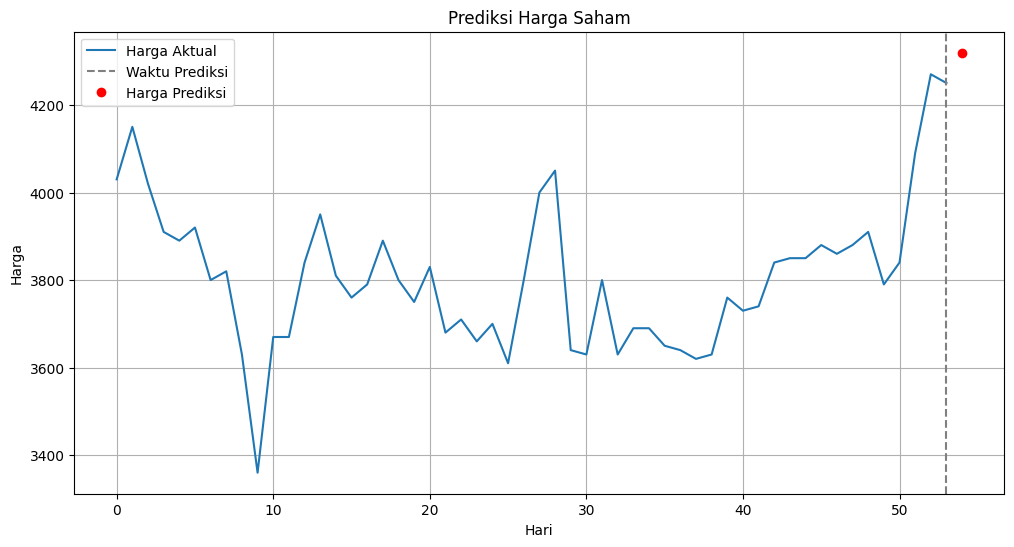

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Nadam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# === 1. Load Data ===
file_path = 'bbri.csv'
data = pd.read_csv(file_path)

# Bersihkan kolom 'Close'
data['Close'] = data['Close'].astype(str).str.replace(',', '', regex=False)
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
data.dropna(subset=['Close'], inplace=True)

# Konversi dan urutkan tanggal
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y', errors='coerce')
data.dropna(subset=['Date'], inplace=True)
data.sort_values('Date', inplace=True)
data.set_index('Date', inplace=True)

# Ambil data close
close_data = data['Close'].values.reshape(-1, 1)
print(f"📊 Total data setelah pembersihan: {len(close_data)}")

# === 2. Tentukan time_step yang aman ===
max_time_step = len(close_data) - 2
if max_time_step < 10:
    raise ValueError("❌ Data terlalu sedikit. Dibutuhkan minimal 12 baris data.")

time_step = min(60, max(10, max_time_step))  # Sesuaikan time_step secara otomatis
print(f"⏱️ time_step yang digunakan: {time_step}")

# === 3. Scaling ===
scaler = MinMaxScaler(feature_range=(0, 1))
close_data_scaled = scaler.fit_transform(close_data)

# Fungsi membuat dataset
def create_dataset(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Buat data training
X, y = create_dataset(close_data_scaled, time_step)

if X.size == 0 or y.size == 0:
    raise ValueError(f"❌ Gagal membuat dataset dengan time_step={time_step}. "
                     f"Dibutuhkan minimal {time_step + 2} baris data.")

X = X.reshape(X.shape[0], X.shape[1], 1)

# === 4. Bangun dan latih model ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32),
    Dense(1)
])
model.compile(optimizer=Nadam(), loss='mean_squared_error')
model.fit(X, y, epochs=200, batch_size=16, verbose=1)

# === 5. Prediksi hari berikutnya ===
def make_prediction(model, data, time_step):
    data_reshaped = data.reshape(1, time_step, 1)
    prediction = model.predict(data_reshaped, verbose=0)
    return prediction[0, 0]

last_60_days = close_data_scaled[-time_step:]
predicted_scaled = make_prediction(model, last_60_days, time_step)
predicted_price = scaler.inverse_transform(np.array([[predicted_scaled]]))

print(f"\n📈 Harga saham yang diprediksi: {predicted_price[0, 0]:.2f}")

# === 6. Visualisasi ===
plt.figure(figsize=(12, 6))
plt.plot(close_data, label='Harga Aktual')
plt.axvline(x=len(close_data) - 1, color='gray', linestyle='--', label='Waktu Prediksi')
plt.plot(len(close_data), predicted_price[0, 0], 'ro', label='Harga Prediksi')
plt.title('Prediksi Harga Saham')
plt.xlabel('Hari')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()
